## Table of Contents
* [Introduction](#introduction)

* [Valuation Results](#valuation_results)
    * [Deltas](#deltas)
    * [Intrinsic Profile](#intrinsic_profile)
    * [Trigger Prices](#trigger_prices)
    * [Simulated Values](#simulated_values)

* [Instrumentation](#instrumentation)
    * [Progress Callback](#progress_callback)
    * [Logging](#logging)


<a id='introduction'></a>
### Introduction
This notebook describes how to value storage using the Least Squares Monte Carlo multi-factor valuation model using the Python API. As a prerequisite please first study the notebook [creating_storage_instances](creating_storage_instances.ipynb) which describes how to create instances of CmdtyStorage which represent the storage facility.



In [1]:
# Common Imports
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, multi_factor_value
import pandas as pd
import ipywidgets as ipw
from IPython.display import display

#### Storage Object
For all examples the following storage with ratchets is used.

In [2]:
storage = CmdtyStorage(
    freq='D',
    storage_start = '2021-04-01',
    storage_end = '2022-04-01',
    injection_cost = 0.01,
    withdrawal_cost = 0.025,
    constraints= [
                ('2021-04-01', # For days after 2021-04-01 (inclusive) until 2022-10-01 (exclusive):
                       [
                            (0.0, -150.0, 250.0),    # At min inventory of zero, max withdrawal of 150, max injection 250
                            (2000.0, -200.0, 175.0), # At inventory of 2000, max withdrawal of 200, max injection 175
                            (5000.0, -260.0, 155.0), # At inventory of 5000, max withdrawal of 260, max injection 155
                            (7000.0, -275.0, 132.0), # At max inventory of 7000, max withdrawal of 275, max injection 132
                        ]),
                  ('2022-10-01', # For days after 2022-10-01 (inclusive):
                       [
                            (0.0, -130.0, 260.0),    # At min inventory of zero, max withdrawal of 130, max injection 260
                            (2000.0, -190.0, 190.0), # At inventory of 2000, max withdrawal of 190, max injection 190
                            (5000.0, -230.0, 165.0), # At inventory of 5000, max withdrawal of 230, max injection 165
                            (7000.0, -245.0, 148.0), # At max inventory of 7000, max withdrawal of 245, max injection 148
                        ]),
                 ]
)

#### Forward Curve
The following natural gas forward curve is used in all examples. This is a monthly curve, converted to daily granularity with piecewise flat interpolation. To create smooth daily curves, with day-of-week seasonality see [Cmdty Curves](https://github.com/cmdty/curves).

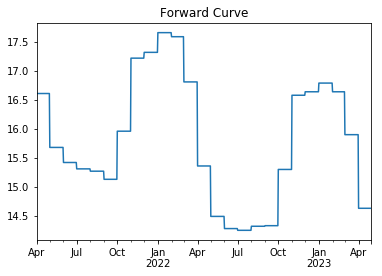

In [3]:
monthly_index = pd.period_range(start='2021-04-25', periods=25, freq='M')
monthly_fwd_prices = [16.61, 15.68, 15.42, 15.31, 15.27, 15.13, 15.96, 17.22, 17.32, 17.66, 
                      17.59, 16.81, 15.36, 14.49, 14.28, 14.25, 14.32, 14.33, 15.30, 16.58, 
                      16.64, 16.79, 16.64, 15.90, 14.63]
fwd_curve = pd.Series(data=monthly_fwd_prices, index=monthly_index).resample('D').fillna('pad')
%matplotlib inline
fwd_curve.plot(title='Forward Curve')

#### Interest Rates Curve
Act/365 continuously compounded interest rates are provided as a Pandas Series instance. In these examples, for simplicity a linearly interpolated rates curve is used. 

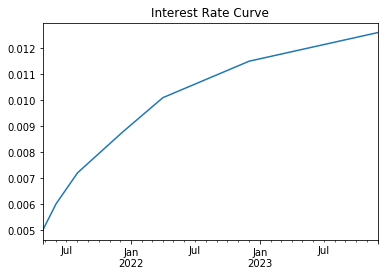

In [4]:
rates = [0.005, 0.006, 0.0072, 0.0087, 0.0101, 0.0115, 0.0126]
rates_pillars = pd.PeriodIndex(freq='D', data=['2021-04-25', '2021-06-01', '2021-08-01', '2021-12-01', '2022-04-01', 
                                              '2022-12-01', '2023-12-01'])
ir_curve = pd.Series(data=rates, index=rates_pillars).resample('D').asfreq('D').interpolate(method='linear')
ir_curve.plot(title='Interest Rate Curve')

<a id='three_factor_seasonal'></a>
### Three Factor Seasonal Model
This section gives an example of using the storage valuation model where the commodity price dynamics are assumed to follow a three-factor seasonal model. The stochastic price model is described in [this paper](https://github.com/cmdty/core/blob/master/docs/three_factor_seasonal_model/three_factor_seasonal_model.pdf), which is a special case of the more general [multi-factor model](https://github.com/cmdty/core/blob/master/docs/multifactor_price_process/multifactor_price_process.pdf). The three factor model is particularly suited power and natural gas which show seaonality in the volatility and correlation.

In [5]:
three_factor_results = three_factor_seasonal_value(
    cmdty_storage = storage,
    val_date = '2021-04-25',
    inventory = 1500.0,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = lambda decision_date: decision_date.asfreq('M').asfreq('D', 'end') + 20,
    spot_mean_reversion = 45.0,
    spot_vol = 0.65,
    long_term_vol = 0.21,
    seasonal_vol = 0.18,
    num_sims = 500,
    basis_funcs = '1 + x_st + x_sw + x_lt + x_st**2 + x_sw**2 + x_lt**2 + x_st**3 + x_sw**3 + x_lt**3',
    discount_deltas=True
)

<a id='valuation_results'></a>
## Valuation Results
The **three_factor_seasonal_value** function call above returns an instance of **MultiFactorValuationResults**, which derives from NamedTuple and has many properties for the results of the optimisation, plus other metadata from the calculations.

The the following attributes give information on the NPV (Net Present Value):
* **npv** is the full NPV including the option value.
* **intrinsic_npv** is the NPV calculated using a static optimisation assuming prices are deterministic, i.e. giving the storage no option value.
* **extrinsic_npv** is the value of just the optionality, i.e. npv minus intrinsic_npv.

In [6]:
print('Full NPV:\t{0:,.0f}'.format(three_factor_results.npv))
print('Intrinsic NPV: \t{0:,.0f}'.format(three_factor_results.intrinsic_npv))
print('Extrinsic NPV: \t{0:,.0f}'.format(three_factor_results.extrinsic_npv))

Full NPV:	73,110
Intrinsic NPV: 	40,976
Extrinsic NPV: 	32,134


<a id='deltas'></a>
### Deltas
The **deltas** property is of type pandas.Series and contains the senstivity of the full NPV to the forward price, for each future period. This is calculated using pathwise differentiation as part of the Monte Carlo simulation, hence if not many simulation paths are used, as in this example, it can look quite jagged. With a higher number of simulations this should look smoother.

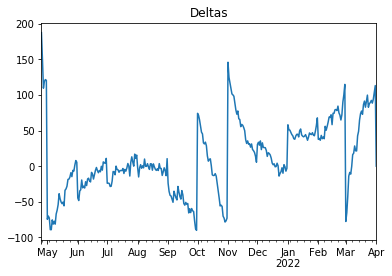

In [7]:
three_factor_results.deltas.plot(title='Deltas')

<a id='intrinsic_profile'></a>
### Intrinsic Profile
The **intrinsic_profile** property is of type pandas.DataFrame and contains information for each future time period on the optimisation performed for the intrinsic valuation. 

In [8]:
three_factor_results.intrinsic_profile

,inventory,inject_withdraw_volume,cmdty_consumed,inventory_loss,net_volume,period_pv
2021-04-25,1312.500000,-187.500000,0.0,0.0,187.500000,3108.477038
2021-04-26,1129.687500,-182.812500,0.0,0.0,182.812500,3030.765175
2021-04-27,951.445312,-178.242188,0.0,0.0,178.242188,2954.996108
2021-04-28,777.659180,-173.786133,0.0,0.0,173.786133,2881.121266
2021-04-29,608.217700,-169.441479,0.0,0.0,169.441479,2809.093295
...,...,...,...,...,...,...
2022-03-28,0.000000,0.000000,0.0,0.0,-0.000000,-0.000000
2022-03-29,0.000000,0.000000,0.0,0.0,-0.000000,-0.000000
2022-03-30,0.000000,0.000000,0.0,0.0,-0.000000,-0.000000
2022-03-31,0.000000,0.000000,0.0,0.0,-0.000000,-0.000000


<a id='trigger_prices'></a>
### Trigger Prices
The **trigger_prices** property contains information on "trigger prices" which are approximate spot price levels at which the exercise decision changes.
* The withdraw trigger price is the spot price level, at time of nomination, above which the optimal decision will change to withdraw.
* The inject trigger price is the spot price level, at time of nomination, below which the optimal decision will change to inject.



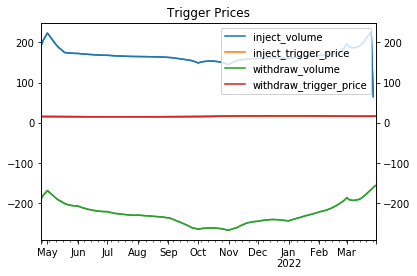

In [10]:
ax1 = three_factor_results.trigger_prices.plot(title='Trigger Prices')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
three_factor_results.trigger_prices.plot(ax=ax2)


<a id='simulated_values'></a>
### Simulated Values
**MultiFactorValuationResults** has a number of properties of type pandas.DataFrame which information at the individual simulation level from the internals of the Least Squares Monte Carlo valuation. For each of these the 

In [40]:
three_factor_results.sim_spot_regress.columns

RangeIndex(start=0, stop=500, step=1)

<a id='instrumentation'></a>
## Instrumentation
There are two ways to instrument the valuation code: an on progress call-back and logging. This section describes both of these. 


<a id='progress_callback'></a>
### Progress Callback
Both valuation functions have an optional argument **on_progress_update** which should be assigned to a callable (i.e. a function) which accepts one argument and has void return. When running the valuation the callable will be invoked with a float instance passed in to the single argument with a numeric approximation of the percentage progress of the total calculation. A typical usage scenario would be to wire this up to a progress bar. This is particularly important from a usability perspective, when a high number of Monte-Carlo simulations are used, hence the calculations can take a long time.

The example below demonstrates this with a IPython progress bar widget.

In [25]:
progress_wgt = ipw.FloatProgress(min=0.0, max=1.0)

def on_progress(progress):
    progress_wgt.value = progress

def btn_value_progress_clicked(b):
    on_progress_demo_results = three_factor_seasonal_value(
        cmdty_storage = storage,
        val_date = '2021-04-25',
        inventory = 1500.0,
        fwd_curve = fwd_curve,
        interest_rates = ir_curve,
        settlement_rule = lambda decision_date: decision_date.asfreq('M').asfreq('D', 'end') + 20,
        spot_mean_reversion = 45.0,
        spot_vol = 0.65,
        long_term_vol = 0.21,
        seasonal_vol = 0.18,
        num_sims = 500,
        basis_funcs = '1 + x_st + x_sw + x_lt + x_st**2 + x_sw**2 + x_lt**2 + x_st**3 + x_sw**3 + x_lt**3',
        discount_deltas=True,
        on_progress_update = on_progress
    )
    
btn_calc_value_progress = ipw.Button(description='Calc Storage Value')
btn_calc_value_progress.on_click(btn_value_progress_clicked)
display(btn_calc_value_progress)
display(progress_wgt)

Button(description='Calc Storage Value', style=ButtonStyle())

FloatProgress(value=0.0, max=1.0)

<a id='logging'></a>
### Loggging
The cmdty_storage package makes use of the [standard Python logging module](https://docs.python.org/3/library/logging.html) by exposing a logger object at the level of the multi_factor module, which will be created with the name 'cmdty.storage.multi-factor'. A log handler can be added to this in order to direct the logged information to the desired destination. See the [logging advanced tutorial](https://docs.python.org/3/howto/logging.html#logging-advanced-tutorial) for more information on using appenders.

The following uses slightly modified code from an example in the ipywideget [documentation](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html#Integrating-output-widgets-with-the-logging-module) to create a custom logging handler which prints to an [Output widget](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html).

In [36]:
from cmdty_storage import multi_factor
import logging

class OutputWidgetHandler(logging.Handler):
    """ Custom logging handler sending logs to an output widget """

    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)
        layout = {
            'width': '100%',
            'height': '160px',
            'border': '1px solid black',
            'overflow_y': 'auto',
        }
        self.out = ipw.Output(layout=layout)

    def emit(self, record):
        """ Overload of logging.Handler method """
        formatted_record = self.format(record)
        new_output = {
            'name': 'stdout',
            'output_type': 'stream',
            'text': formatted_record+'\n'
        }
        self.out.outputs = self.out.outputs + (new_output, )

    def show_logs(self):
        """ Show the logs """
        display(self.out)

    def clear_logs(self):
        """ Clear the current logs """
        self.out.clear_output()

handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))

multi_factor.logger.setLevel(logging.INFO)

def btn_value_logging_clicked(b):
    multi_factor.logger.addHandler(handler)
    logging_demo_results = three_factor_seasonal_value(
        cmdty_storage = storage,
        val_date = '2021-04-25',
        inventory = 1500.0,
        fwd_curve = fwd_curve,
        interest_rates = ir_curve,
        settlement_rule = lambda decision_date: decision_date.asfreq('M').asfreq('D', 'end') + 20,
        spot_mean_reversion = 45.0,
        spot_vol = 0.65,
        long_term_vol = 0.21,
        seasonal_vol = 0.18,
        num_sims = 500,
        basis_funcs = '1 + x_st + x_sw + x_lt + x_st**2 + x_sw**2 + x_lt**2 + x_st**3 + x_sw**3 + x_lt**3',
        discount_deltas=True,
    )
    multi_factor.logger.removeHandler(handler)

def btn_on_clear_logs_clicked(b):
    handler.clear_logs()
    
btn_calc_value_logging = ipw.Button(description='Calc Storage Value')
btn_calc_value_logging.on_click(btn_value_logging_clicked)
display(btn_calc_value_logging)

btn_clear_logs = ipw.Button(description='Clear Logs')
btn_clear_logs.on_click(btn_on_clear_logs_clicked)
display(btn_clear_logs)

handler.show_logs()

Button(description='Calc Storage Value', style=ButtonStyle())

Button(description='Clear Logs', style=ButtonStyle())

Output(layout=Layout(border='1px solid black', height='160px', overflow_y='auto', width='100%'))